# Naive Bayes Classification

In this section we will be taking a closer look at the naive Bayes classification algorithm. 

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

We begin with the standard imports:



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Example 1: Classifying Text

Naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.

Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

The 20 Newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). 

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [4]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [5]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In [6]:
train.target

array([2, 2, 1, ..., 2, 3, 1], dtype=int64)

Text data requires special preparation before you can start using it for predictive modeling. We cannot work with text directly when using machine learning algorithms.Instead, we need to convert the text to numbers (or a vector of numbers).

We want to perform classification of documents, so each document is an “input” and a class label is the “output” for our predictive algorithm. Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.

For this we will use the **Count Vectorizer**, which provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.



In [7]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline


vectorizer = CountVectorizer()

# fit vocabulary -> X will contain our vextorized train data
X = vectorizer.fit_transform(train.data)

In [8]:
# take a look at the features
features = vectorizer.get_feature_names()

print('Number of features: ' + str(len(features)))
features[20000:20010]

Number of features: 35329


['light',
 'light_source',
 'lighter',
 'lightest',
 'lighthearted',
 'lighting',
 'lightly',
 'lightness',
 'lightning',
 'lights']

For each document an encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

Because these vectors will contain a lot of zeros, we call them sparse. Python provides an efficient way of handling sparse vectors in the scipy.sparse package.

The vectors returned from a call to transform() will be sparse vectors, and you can transform them back to numpy arrays to look and better understand what is going on by calling the toarray() function.

In [9]:
vectorized_documents = X.toarray()
vectorized_documents

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
vectorized_documents[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

We can now apply the Naive Bayes classifier. For this we will create a pipeline that attaches the count vectorizer to the naive Bayes classifier:

In [11]:
model = make_pipeline(vectorizer, MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [12]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

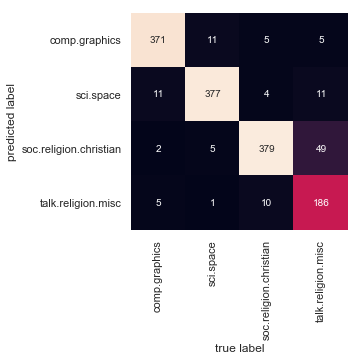

In [13]:
from sklearn.metrics import confusion_matrix

# build the confusion matrix
mat = confusion_matrix(test.target, labels)

# create a headmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [14]:
from sklearn.metrics import accuracy_score
print("Accuracy = {} %".format(accuracy_score(test.target, labels)*100))

Accuracy = 91.68994413407822 %


Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets a bit confused between talk about religion and talk about Christianity. This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for any string, using the predict() method of this pipeline. Here's a quick utility function that will return the prediction for a single string:

In [15]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [16]:
predict_category('ending a payload to the ISS')

'sci.space'

In [17]:
predict_category('discussing islam vs atheism')

'talk.religion.misc'

In [18]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## Example 2: Recognize Handwriten Digits

In this section we're going to use Naive Bayes to classify handwritten digits.

For this we'll use the MNIST dataset, which is one of the most common datasets used for image classification and accessible from many different sources

The MNIST data comprises of digital images of several digits ranging from 0 to 9. Each image is 28 x 28 pixels. Thus, the data set has 10 levels of classes

In [19]:
from sklearn.datasets import fetch_openml

# X contains the data and y contains the labels
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

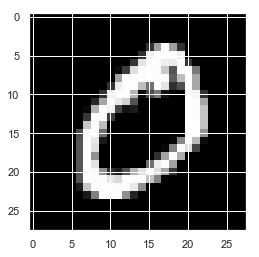

label: 0


In [20]:
im = X[1].reshape((28,28))

plt.imshow(im, cmap='gray')
plt.show()
print('label: ' + str(y[1]))

Let's split the data into train and test

In [21]:
# Split the data into training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [22]:
print('Train set', len(x_train))
print('Test set', len(x_test))

Train set 66500
Test set 3500


We'll train the model on the train data:

In [23]:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Now let's look how the model behaves on the test data:

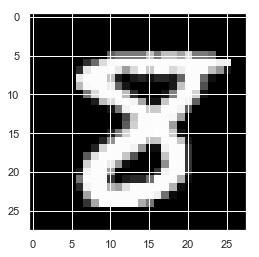

true label:  8


In [24]:
im = x_test[0].reshape((28,28))

plt.imshow(im, cmap='gray')
plt.show()
print('true label: ', y_test[0])

In [25]:
# predicted label
label = model.predict(x_test[0].reshape(-1, 1).T)
print('predicted label: ', label)

predicted label:  ['8']


Now we'll make predictions for all the test data and take a look at the confusion matrix:

In [26]:
predictions = model.predict(x_test)
predictions

array(['8', '4', '5', ..., '7', '7', '2'], dtype='<U1')

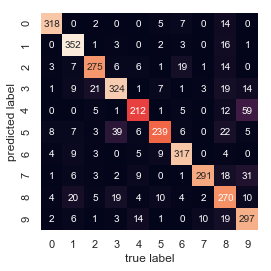

In [27]:
from sklearn.metrics import confusion_matrix

# build the confusion matrix
mat = confusion_matrix(predictions, y_test)

# create a headmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [28]:
from sklearn.metrics import accuracy_score
print("Accuracy = {} %".format(accuracy_score(y_test, predictions)*100))

Accuracy = 82.71428571428572 %
